In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
 
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PathCollection

from scipy import stat

In [2]:
telco_pd = pd.read_csv("testset.csv")
inp = pd.read_csv("082823-inpatient-adult-RSV-encounters.csv")
rsva = pd.read_csv("/Users/estefanyguzman/Documents/Northwestern/PhD/Thesis-Work/RSV-Sequencing/qPCR/Files_python/090123-RSVA-dummy.csv")
rsvb = pd.read_csv("/Users/estefanyguzman/Documents/Northwestern/PhD/Thesis-Work/RSV-Sequencing/qPCR/Files_python/090123-RSVB-dummy.csv")
ct = pd.read_csv("/Users/estefanyguzman/Documents/Northwestern/PhD/Thesis-Work/RSV-Sequencing/qPCR/Files_python/090123-CT-dummy.csv")
season = pd.read_csv("/Users/estefanyguzman/Documents/Northwestern/PhD/Thesis-Work/RSV-Sequencing/qPCR/Files_python/090123-seasonality-info.csv")
adlt_sub = pd.read_csv("091023adlt_ND_boolean.csv")
ped_sub = pd.read_csv("102323ped_ND_boolean.csv")

# Fig 3A: Subtype switching

In [5]:
#Identifying the date of earliest to latest sample within the adult subtype dataframe
adlt_sub['Date_of_Flu_Lab'].max()

'2023-03-01'

In [25]:
#Checking the dates for the oldest and latest RSV adult patient encounter with subtyping information
subtype = adlt_sub[adlt_sub['subtype'] != 'Unknown']
subtype_clean = subtype[subtype['subtype'].notna()]
subtype_clean['Date_of_Admission'].max()

'2022-12-29'

In [32]:
l = subtype_clean[subtype_clean['Date_of_Admission'] == '2022-12-29' ]
l['Lab_type']

3032    Unknown
Name: Lab_type, dtype: object

In [17]:
#Checking the distribution of inpatients, outpatients, and ICU admins
Unknown = adlt_sub[adlt_sub['subtype'] == 'Unknown']
Unknown_count = Unknown[['ir_id','season']].groupby(['season'])['season'].size().reset_index(name='Unknown')

A = adlt_sub[adlt_sub['subtype'] == 'A']
A_count = A[['ir_id','season']].groupby(['season'])['season'].size().reset_index(name='A')

B = adlt_sub[adlt_sub['subtype'] == 'B']
B_count = B[['ir_id','season']].groupby(['season'])['season'].size().reset_index(name='B')

#Merging together datasets
cat_count0 =pd.merge(B_count, A_count, on='season', how='left').fillna(0)

cat_count0.loc[len(cat_count0)] = ['2020-2021',0,0] #There are no adult specimen collected in 2020-2021
cat_count0 = cat_count0.sort_values(by='season')

cat_count0

,season,B,A
0,2010-2011,1,1.0
1,2012-2013,2,4.0
2,2013-2014,1,0.0
3,2014-2015,6,8.0
4,2015-2016,8,73.0
5,2016-2017,13,53.0
6,2017-2018,15,47.0
7,2018-2019,1,3.0
8,2019-2020,1,0.0
11,2020-2021,0,0.0


In [18]:
counts = cat_count0.drop(columns=['season'])
data_perc = counts.divide(counts.sum(axis=1), axis=0)

Text(0.5, 0, 'RSV Season')

<Figure size 5400x4800 with 0 Axes>

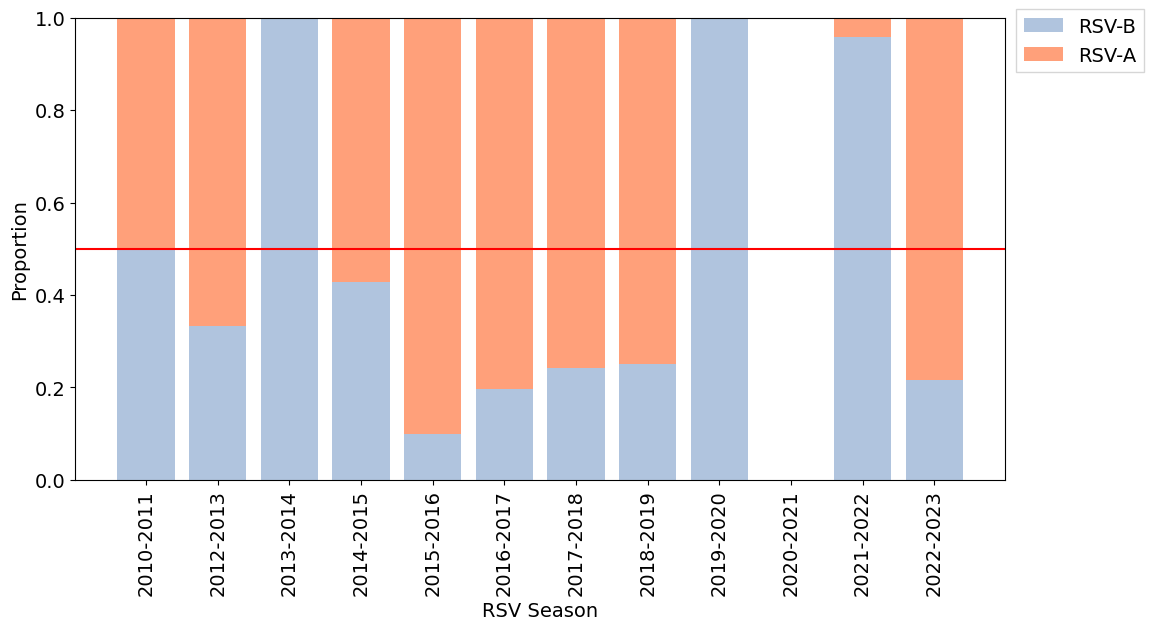

In [19]:
plt.figure(figsize=(9,8), dpi=600)
plt.rcParams.update({'font.size': 14})
x = cat_count0['season']

#proportional
y3p = data_perc['A']
y4p = data_perc['B']

plt.figure(figsize=(12,6))
bars1 = plt.bar(x, y4p, color='lightsteelblue', label='RSV-B')
bars2 = plt.bar(x, y3p, bottom= y4p, color='lightsalmon', label='RSV-A')
plt.xticks(rotation=90)

plt.legend(loc='right', bbox_to_anchor=(1.16, 0.95),
          ncol=1, fancybox=False, shadow=False)


# specifying horizontal line type
plt.axhline(y = 0.5, color = 'r', linestyle = '-')

plt.ylabel('Proportion', fontsize=14)
plt.xlabel('RSV Season', fontsize=14)
#plt.savefig("RSV-subtype-ratio.pdf", format="pdf", bbox_inches="tight")
#plt.savefig('091023-subtype-distribution.svg', format='svg', bbox_inches='tight')

# Figure 3B: Age Distribution of RSV-A and RSV-B

In [65]:
#Stratifying by subtype
A = adlt_sub[adlt_sub['Lab_type'] == "A"]
B = adlt_sub[adlt_sub['Lab_type'] == "B"]

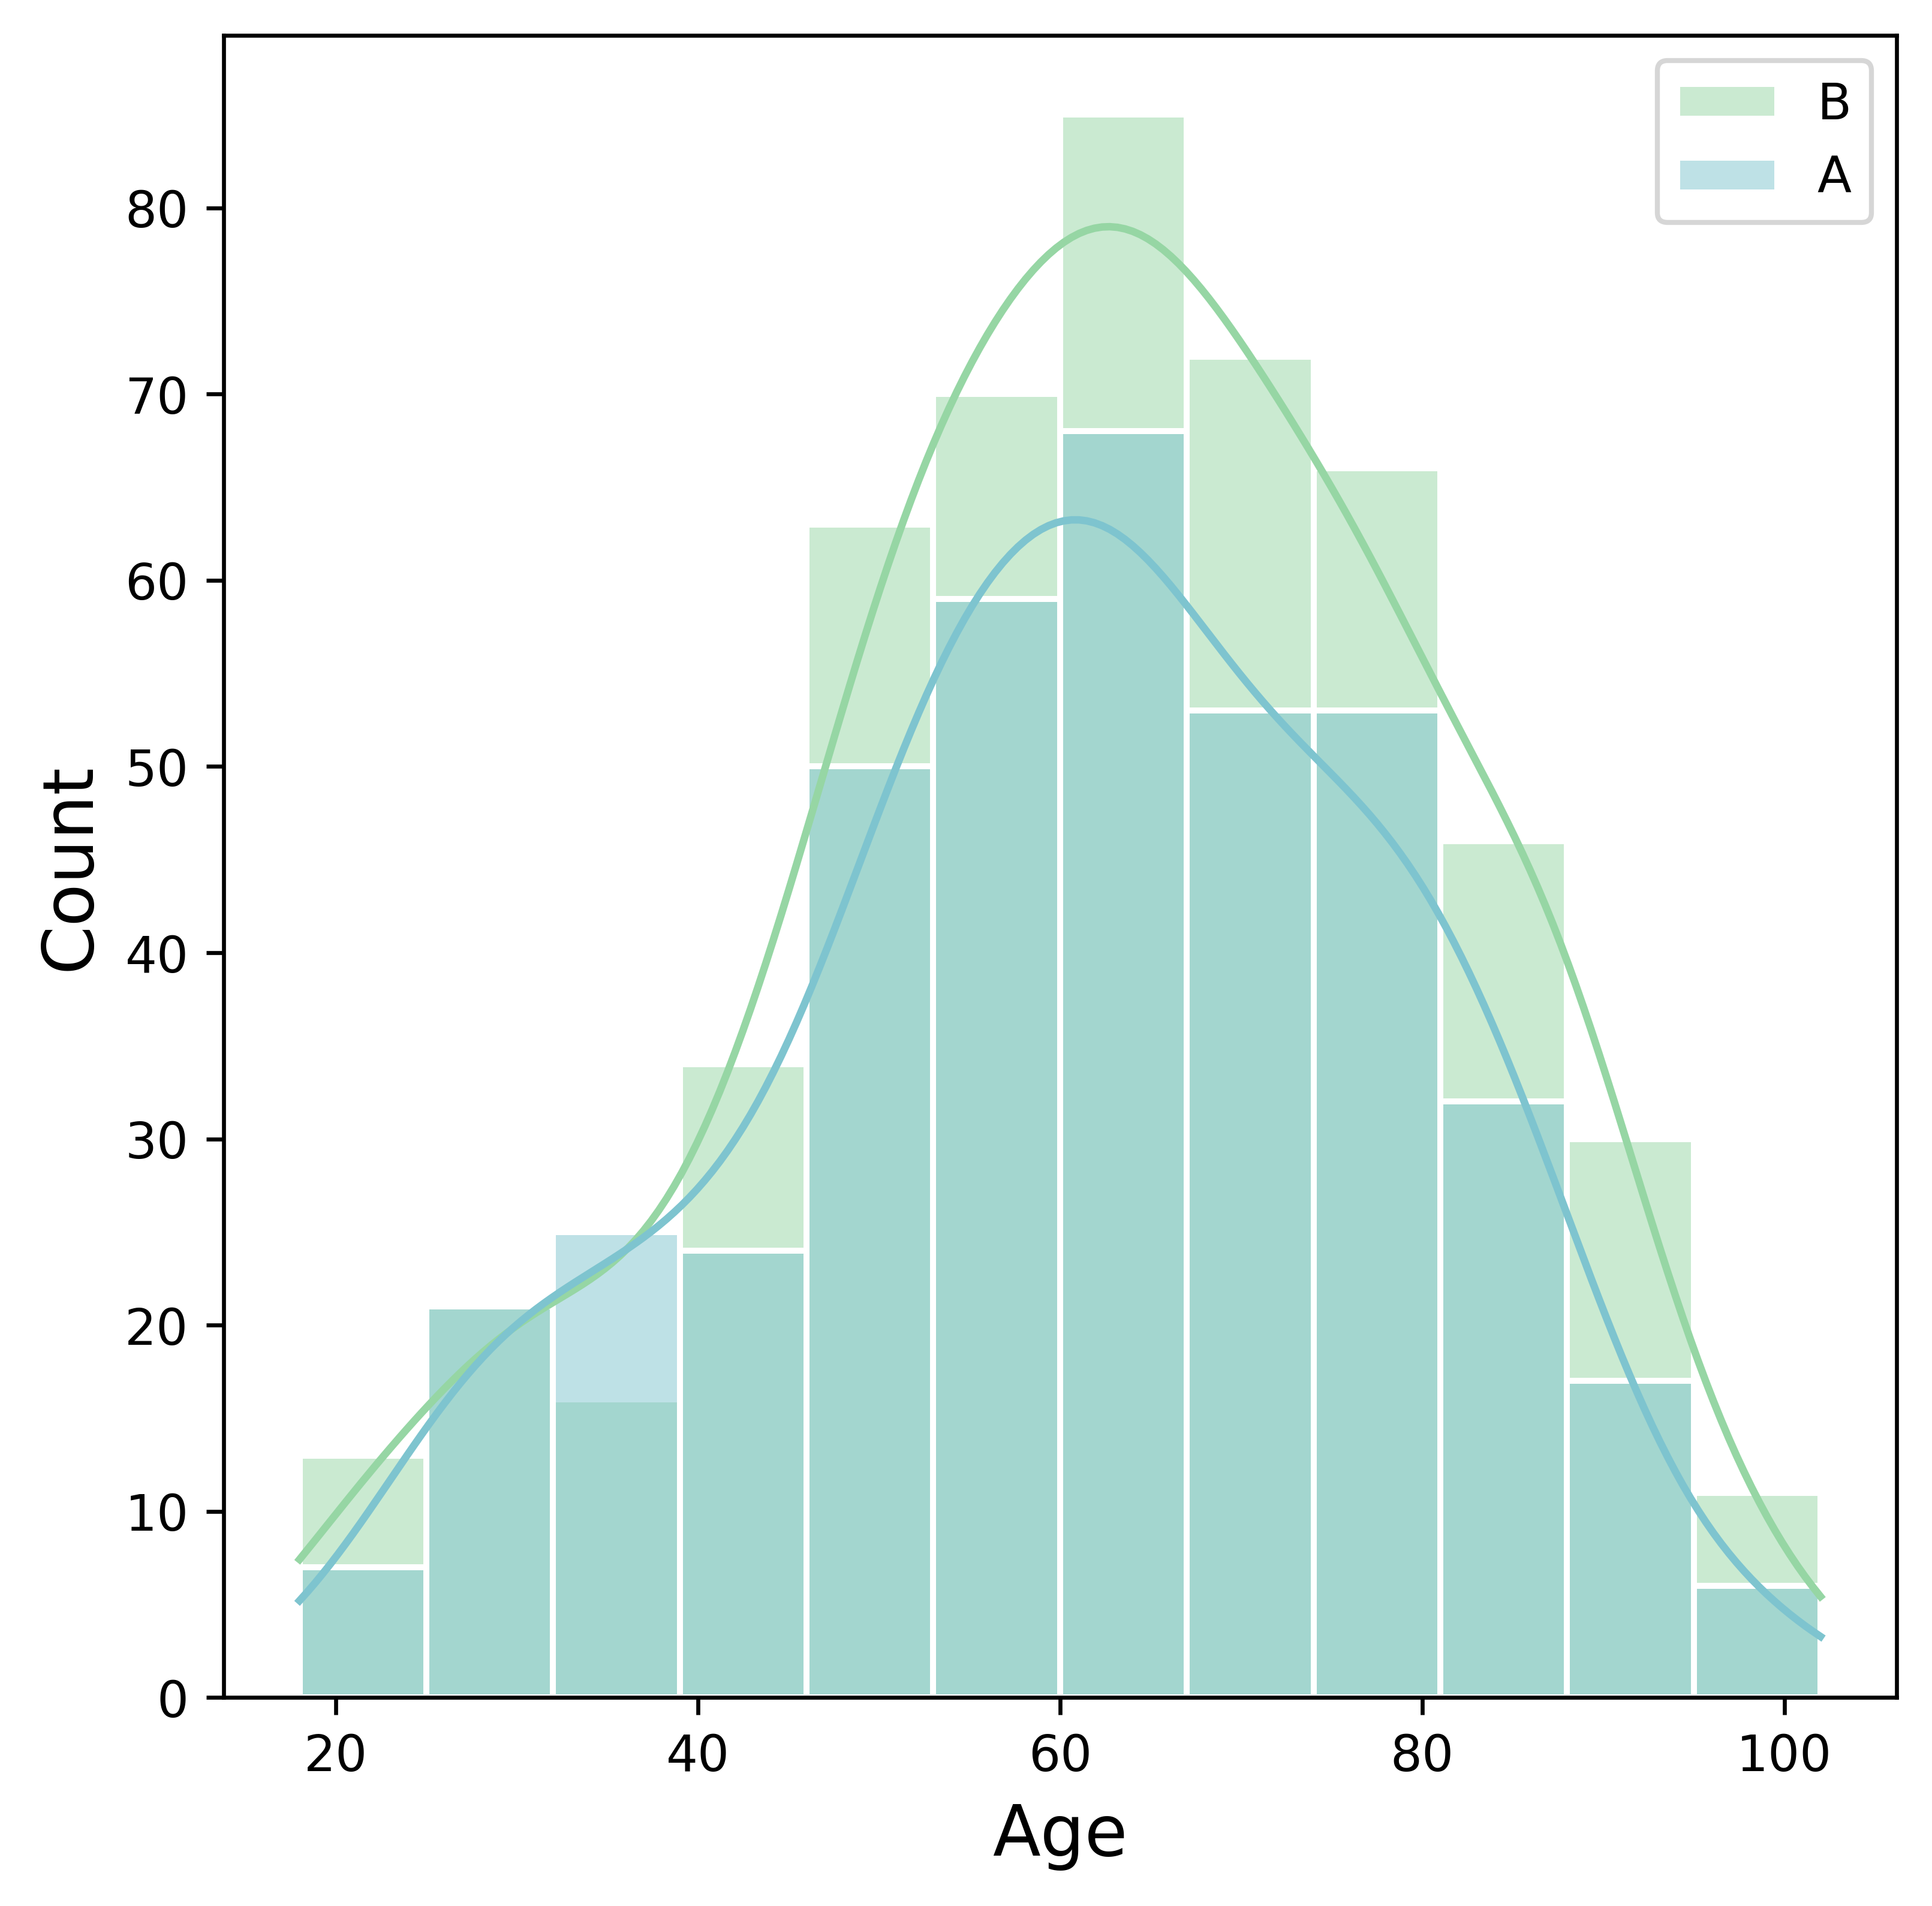

In [16]:
# Eliminating Unknown subtypes in inpatient dataframe
inp = inp[inp['subtype'] != 'Unknown']

plt.figure(figsize=(6,6), dpi=600)
plt.style.use('default')
#Extracting RSV sutype groups (i.e. RSV-A and RSV-B)
unique_groups = inp['subtype'].unique()

#creating subplots per each RSV subtype
inpa = inp[inp['subtype'] == 'A']
inpb = inp[inp['subtype'] == 'B']
inp['Age_at_Admission']

colors = {'A': '#7ec4cf', 'B': '#96d6a4'}

for group in unique_groups:
    group_data = inp[inp['subtype'] == group]['Age_at_Admission']
    sns.histplot(group_data, bins=12, kde=True, label=group, color=colors[group], edgecolor='white', linewidth=1.2)

plt.xlabel("Age", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend()
# Save the entire figure
plt.savefig('101323-age-distribution.svg', format='svg', bbox_inches='tight')
# Show the plot
plt.show()

# Figure 3D: Kaplan Meier Plot for RSV Subtypes

In [82]:
#Changing both Date of Admission and Date of Death for adult inpatients
inp['death_date'] = pd.to_datetime(inp['death_date'])
inp['Date_of_Admission'] = pd.to_datetime(inp['Date_of_Admission'])
inp['Date_of_Discharge'] = pd.to_datetime(inp['Date_of_Discharge'])

#Getting rid of unknown subtypes
inp = inp[inp['subtype'] != 'Unknown']

inpout = inp[inp['LOS_Hospitalization'] <= 20]

#Defining whether this patient was discharged within 30 days
# Function to check if a value is less than or equal to 30
def is_less_than_30(value):
    return 1 if value <= 20 else 0

inpout['IsDis30'] = inpout['LOS_Hospitalization'].apply(lambda x: is_less_than_30(x))

#Populating the difference in days
inp['diff'] =''
inp['diff'] = ((inp['death_date'] - inp['Date_of_Admission']).dt.days).fillna(0)
#T = ((inp['death_date'] - inp['Date_of_Admission']).dt.days).fillna(0)
T = inpout['LOS_Hospitalization']
C = inpout['IsDis30']

/var/folders/3n/4ymlf6h176q558ggsk_z_7nw0000gn/T/ipykernel_90780/2156424592.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpout['IsDis30'] = inpout['LOS_Hospitalization'].apply(lambda x: is_less_than_30(x))


In [83]:
import statistics
median = statistics.median(inp['LOS_Hospitalization'])
median

4.0

In [69]:
import pandas as pd

# Assuming inp is a DataFrame
inp['diff'] = ((inp['death_date'] - inp['Date_of_Admission']).dt.days).fillna(0)

# Use .loc to filter and modify elements
inp.loc[(inp['diff'] > 30), 'RSV_att_dth'] = 0
inp.loc[(inp['diff'] > 30), 'diff'] = 30
T = inp['diff']
C = inp['RSV_att_dth'].astype(float)

kmf = KaplanMeierFitter()
kmf.fit(T,C)

/var/folders/3n/4ymlf6h176q558ggsk_z_7nw0000gn/T/ipykernel_90780/727311395.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp['diff'] = ((inp['death_date'] - inp['Date_of_Admission']).dt.days).fillna(0)


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 942 total observations, 895 right-censored observations>

In [84]:
kmf = KaplanMeierFitter()
kmf.fit(T,C)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 866 total observations, 0 right-censored observations>

In [85]:
event_table = kmf.event_table
event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,19,19,0,866,866
1.0,89,89,0,0,847
2.0,142,142,0,0,758
3.0,115,115,0,0,616
4.0,116,116,0,0,501
5.0,86,86,0,0,385
6.0,43,43,0,0,299
7.0,29,29,0,0,256
8.0,40,40,0,0,227


In [92]:
from matplotlib.ticker import MaxNLocator
# Helper function for plotting Kaplan-Meier curves at the covariate level
def plot_km(col):
  ax = plt.subplot(111)
  for r in inp[col].unique():
    ix = inp[col] == r
    kmf.fit(T[ix], C[ix],label=r)
    kmf.plot(ax=ax)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
 
    
# Helper function for printing out Log-rank test results
def print_logrank(col):
  log_rank = pairwise_logrank_test(inpout['LOS_Hospitalization'], inpout[col], inpout['IsDis30'])
  return log_rank.summary

,,test_statistic,p,-log2(p)
A,B,0.24587,0.619998,0.689664


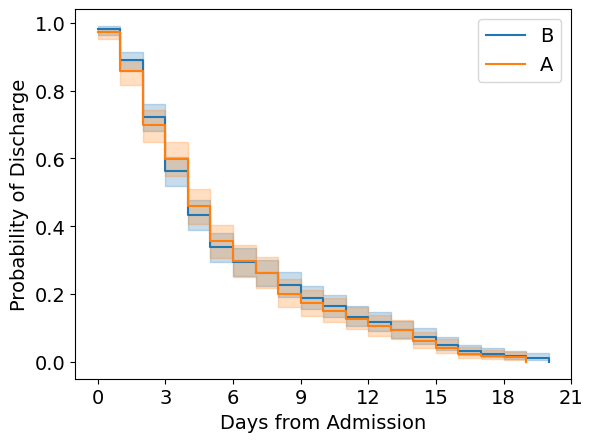

In [93]:
plot_km('subtype') 
plt.xlabel('Days from Admission')
plt.ylabel('Probability of Discharge')
#plt.savefig('092923-KM-plot.svg', format='svg', bbox_inches='tight')
print_logrank('subtype')


# Figure 3C: Proportion of Comorbidities per RSV subtype

In [130]:
a_hiv = inpa['HIV_AIDS'].sum()
a_sot = inpa['Solid_Organ_Tx'].sum()
a_sct = inpa['Stem_cell_Tx'].sum()
a_ld = inpa['Liver_disease_1'].sum()
a_d = inpa['Diabetes_1'].sum()
a_rd = inpa['Renal_disease_1'].sum()
a_c = inpa['Cancer'].sum()
a_a = inpa['Asthma'].sum()
a_cad = inpa['Coronary_Artery_Disease'].sum()
a_h = inpa['Hypertension'].sum()
a_i = inpa['Immunocompromised_status_1'].sum()

In [131]:
b_hiv = inpb['HIV_AIDS'].sum()
b_sot = inpb['Solid_Organ_Tx'].sum()
b_sct = inpb['Stem_cell_Tx'].sum()
b_ld = inpb['Liver_disease_1'].sum()
b_d = inpb['Diabetes_1'].sum()
b_rd = inpb['Renal_disease_1'].sum()
b_c = inpb['Cancer'].sum()
b_a = inpb['Asthma'].sum()
b_cad = inpb['Coronary_Artery_Disease'].sum()
b_h = inpb['Hypertension'].sum()
b_i = inpb['Immunocompromised_status_1'].sum()

In [147]:
#create DataFrame
df = pd.DataFrame(columns=['Solid Organ Transplant', 'Stem Cell Transplant',
                           'Liver Disease', 'Diabetes', 'Renal Disease',
                          'Cancer','Asthma','Coronary Artery Disease',
                          'Hypertension', 'Immunocompromised','HIV'], index=['A','B'])

In [148]:
df.loc['A'] = pd.Series({'Solid Organ Transplant':a_sot, 
                         'Stem Cell Transplant': a_sct, 
                         'Liver Disease': a_ld, 
                         'Diabetes':a_d,
                        'Renal Disease': a_rd,
                        'Cancer': a_c,
                        'Asthma': a_a,
                        'Coronary Artery Disease': a_cad,
                        'Hypertension': a_h,
                        'Immunocompromised': a_i,
                        'HIV': a_hiv})

df.loc['B'] = pd.Series({'Solid Organ Transplant':b_sot, 
                         'Stem Cell Transplant': b_sct, 
                         'Liver Disease': b_ld, 
                         'Diabetes':b_d,
                        'Renal Disease': b_rd,
                        'Cancer': b_c,
                        'Asthma': b_a,
                        'Coronary Artery Disease': b_cad,
                        'Hypertension': b_h,
                        'Immunocompromised': b_i,
                        'HIV': b_hiv})

In [150]:
df.loc['A'] = df.loc['A']/415*100
df.loc['B'] = df.loc['B']/527*100

In [152]:
df = df.T
#df.reset_index()

In [157]:
df = df.sort_values('B', ascending=True)

In [158]:
def butterfly_chart(
        data: pd.DataFrame, 
        title: str = None,
        middle_label_offset=0.01,
        figsize=(5, 2),
        wspace=0.6
    ):
    """ """

    plt.rcParams.update({
        # general
        'figure.facecolor': 'w',
        # font sizes
        'font.size': 12,
        'axes.titlesize': 16,
        'xtick.labelsize': 10,
        # force black border
        'patch.force_edgecolor': True,
        'patch.facecolor': 'black',
        # remove spines
        'axes.spines.bottom': False,
        'axes.spines.left': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'xtick.bottom': False,
        'xtick.top': False,
        'axes.titlepad': 10,
        # grid
        'axes.grid': True,
        'grid.color': 'k',
        'grid.linestyle': ':',
        'grid.linewidth': 0.5,
        'lines.dotted_pattern': [1, 3],
        'lines.scale_dashes': False
    })

    fig, (ax1, ax2) = plt.subplots(
        figsize=figsize,
        dpi=100,
        nrows=1,
        ncols=2,
        subplot_kw={'yticks': []},
        gridspec_kw={'wspace': wspace},
    )

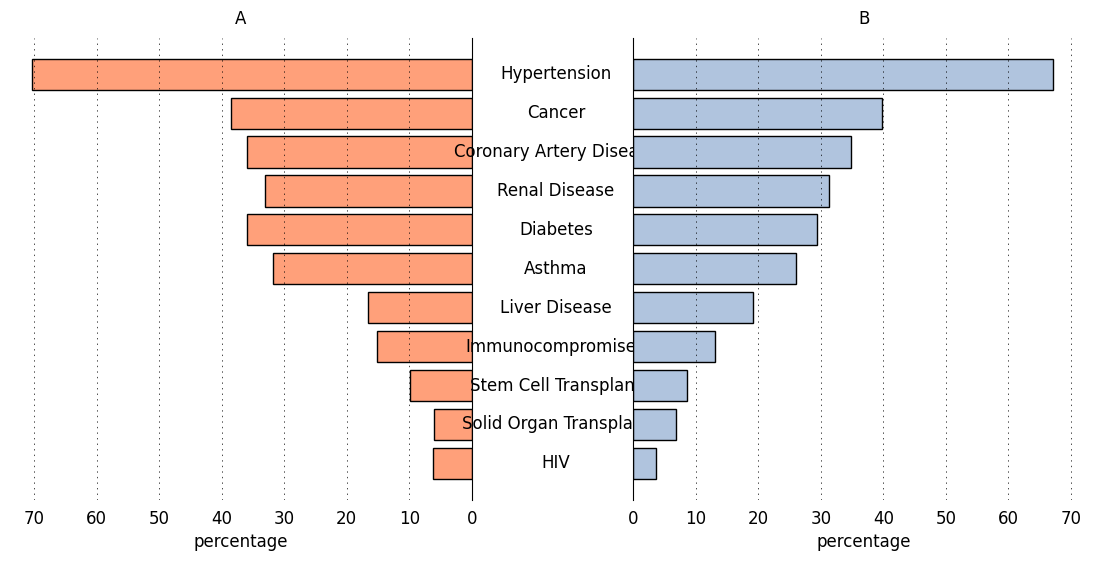

In [175]:
#https://geoffruddock.com/notebooks/data-viz/butterfly-charts/
import matplotlib.ticker as mtick
import matplotlib.transforms as transforms

def butterfly_chart(
        df: pd.DataFrame, 
        title: str = None,
        middle_label_offset=0.01,
        figsize=(6, 2),
    left_width=0.7,  # Increase the left subplot width
    right_width=0.7, 
        wspace=0.6
    ):
    """ """

    plt.rcParams.update({
        # general
        'figure.facecolor': 'w',
        # font sizes
        'font.size': 12,
        'axes.titlesize': 12,
        'xtick.labelsize': 12,
        # force black border
        'patch.force_edgecolor': True,
        'patch.facecolor': 'white',
        # remove spines
        'axes.spines.bottom': False,
        'axes.spines.left': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'xtick.bottom': False,
        'xtick.top': False,
        'axes.titlepad': 10,
        # grid
        'axes.grid': True,
        'grid.color': 'k',
        'grid.linestyle': ':',
        'grid.linewidth': 0.5,
        'lines.dotted_pattern': [1, 3],
        'lines.scale_dashes': False
    })

    fig, (ax1, ax2) = plt.subplots(
        figsize=figsize,
        dpi=100,
        nrows=1,
        ncols=2,
        subplot_kw={'yticks': []},
        gridspec_kw={'wspace': wspace, 'width_ratios': [left_width, right_width]},
    )
    
    
    # plot the 
    (l1, x1), (l2,x2) = df.items()
    y = range(len(x1))
    labels = df.index.tolist()

    ax1.barh(y=y, width=x1, color='#FFA07A')
    ax1.invert_xaxis()
    ax1.set_title(l1)

    ax2.barh(y=y, width=x2, color='#B0C4DE')
    ax2.set_title(l2)
    
    # forced shared xlim
    x_max = max(ax1.get_xlim()[0], ax2.get_xlim()[0])
    ax1.set_xlim((x_max, 0))
    ax2.set_xlim((0, x_max))
    
    # turn on axes spines on the inside y-axis
    ax1.spines['right'].set_visible(True)
    ax2.spines['left'].set_visible(True)
    
    # format axes
    #xfmt = mtick.PercentFormatter(xmax=1, decimals=0)
    #ax1.xaxis.set_major_formatter(xfmt)
    #ax2.xaxis.set_major_formatter(xfmt)

    # place center labels
    transform = transforms.blended_transform_factory(fig.transFigure, ax1.transData)
    for i, label in enumerate(labels):
        ax1.text(0.5+middle_label_offset, i, label, ha='center', va='center', transform=transform)

    plt.suptitle(title, y=1.05, fontsize=12)
    ax1.set_xlabel('percentage', fontsize=12)
    ax2.set_xlabel('percentage', fontsize=12)
    
    
    
butterfly_chart(
    df,
    figsize=(14, 6),
    wspace=0.35,
    middle_label_offset=0.015,
    #title='Proportion of fruit sold at each grocery store'
)

# Save the entire figure
plt.savefig('091023-comorbidity-distribution.svg', format='svg', bbox_inches='tight')
# Show the plot
plt.show()

# Figure 3F: Proportion of ICU admission per RSV Subtype

In [4]:
# Calculate the sum of columns 'A' and 'B'
sum_A = df['A'].sum()
sum_B = df['B'].sum()

# Divide each value in columns 'A' and 'B' by their respective sums
df['A'] = df['A'] / sum_A
df['B'] = df['B'] / sum_B

([0, 1], [Text(0, 0, 'A'), Text(1, 0, 'B')])

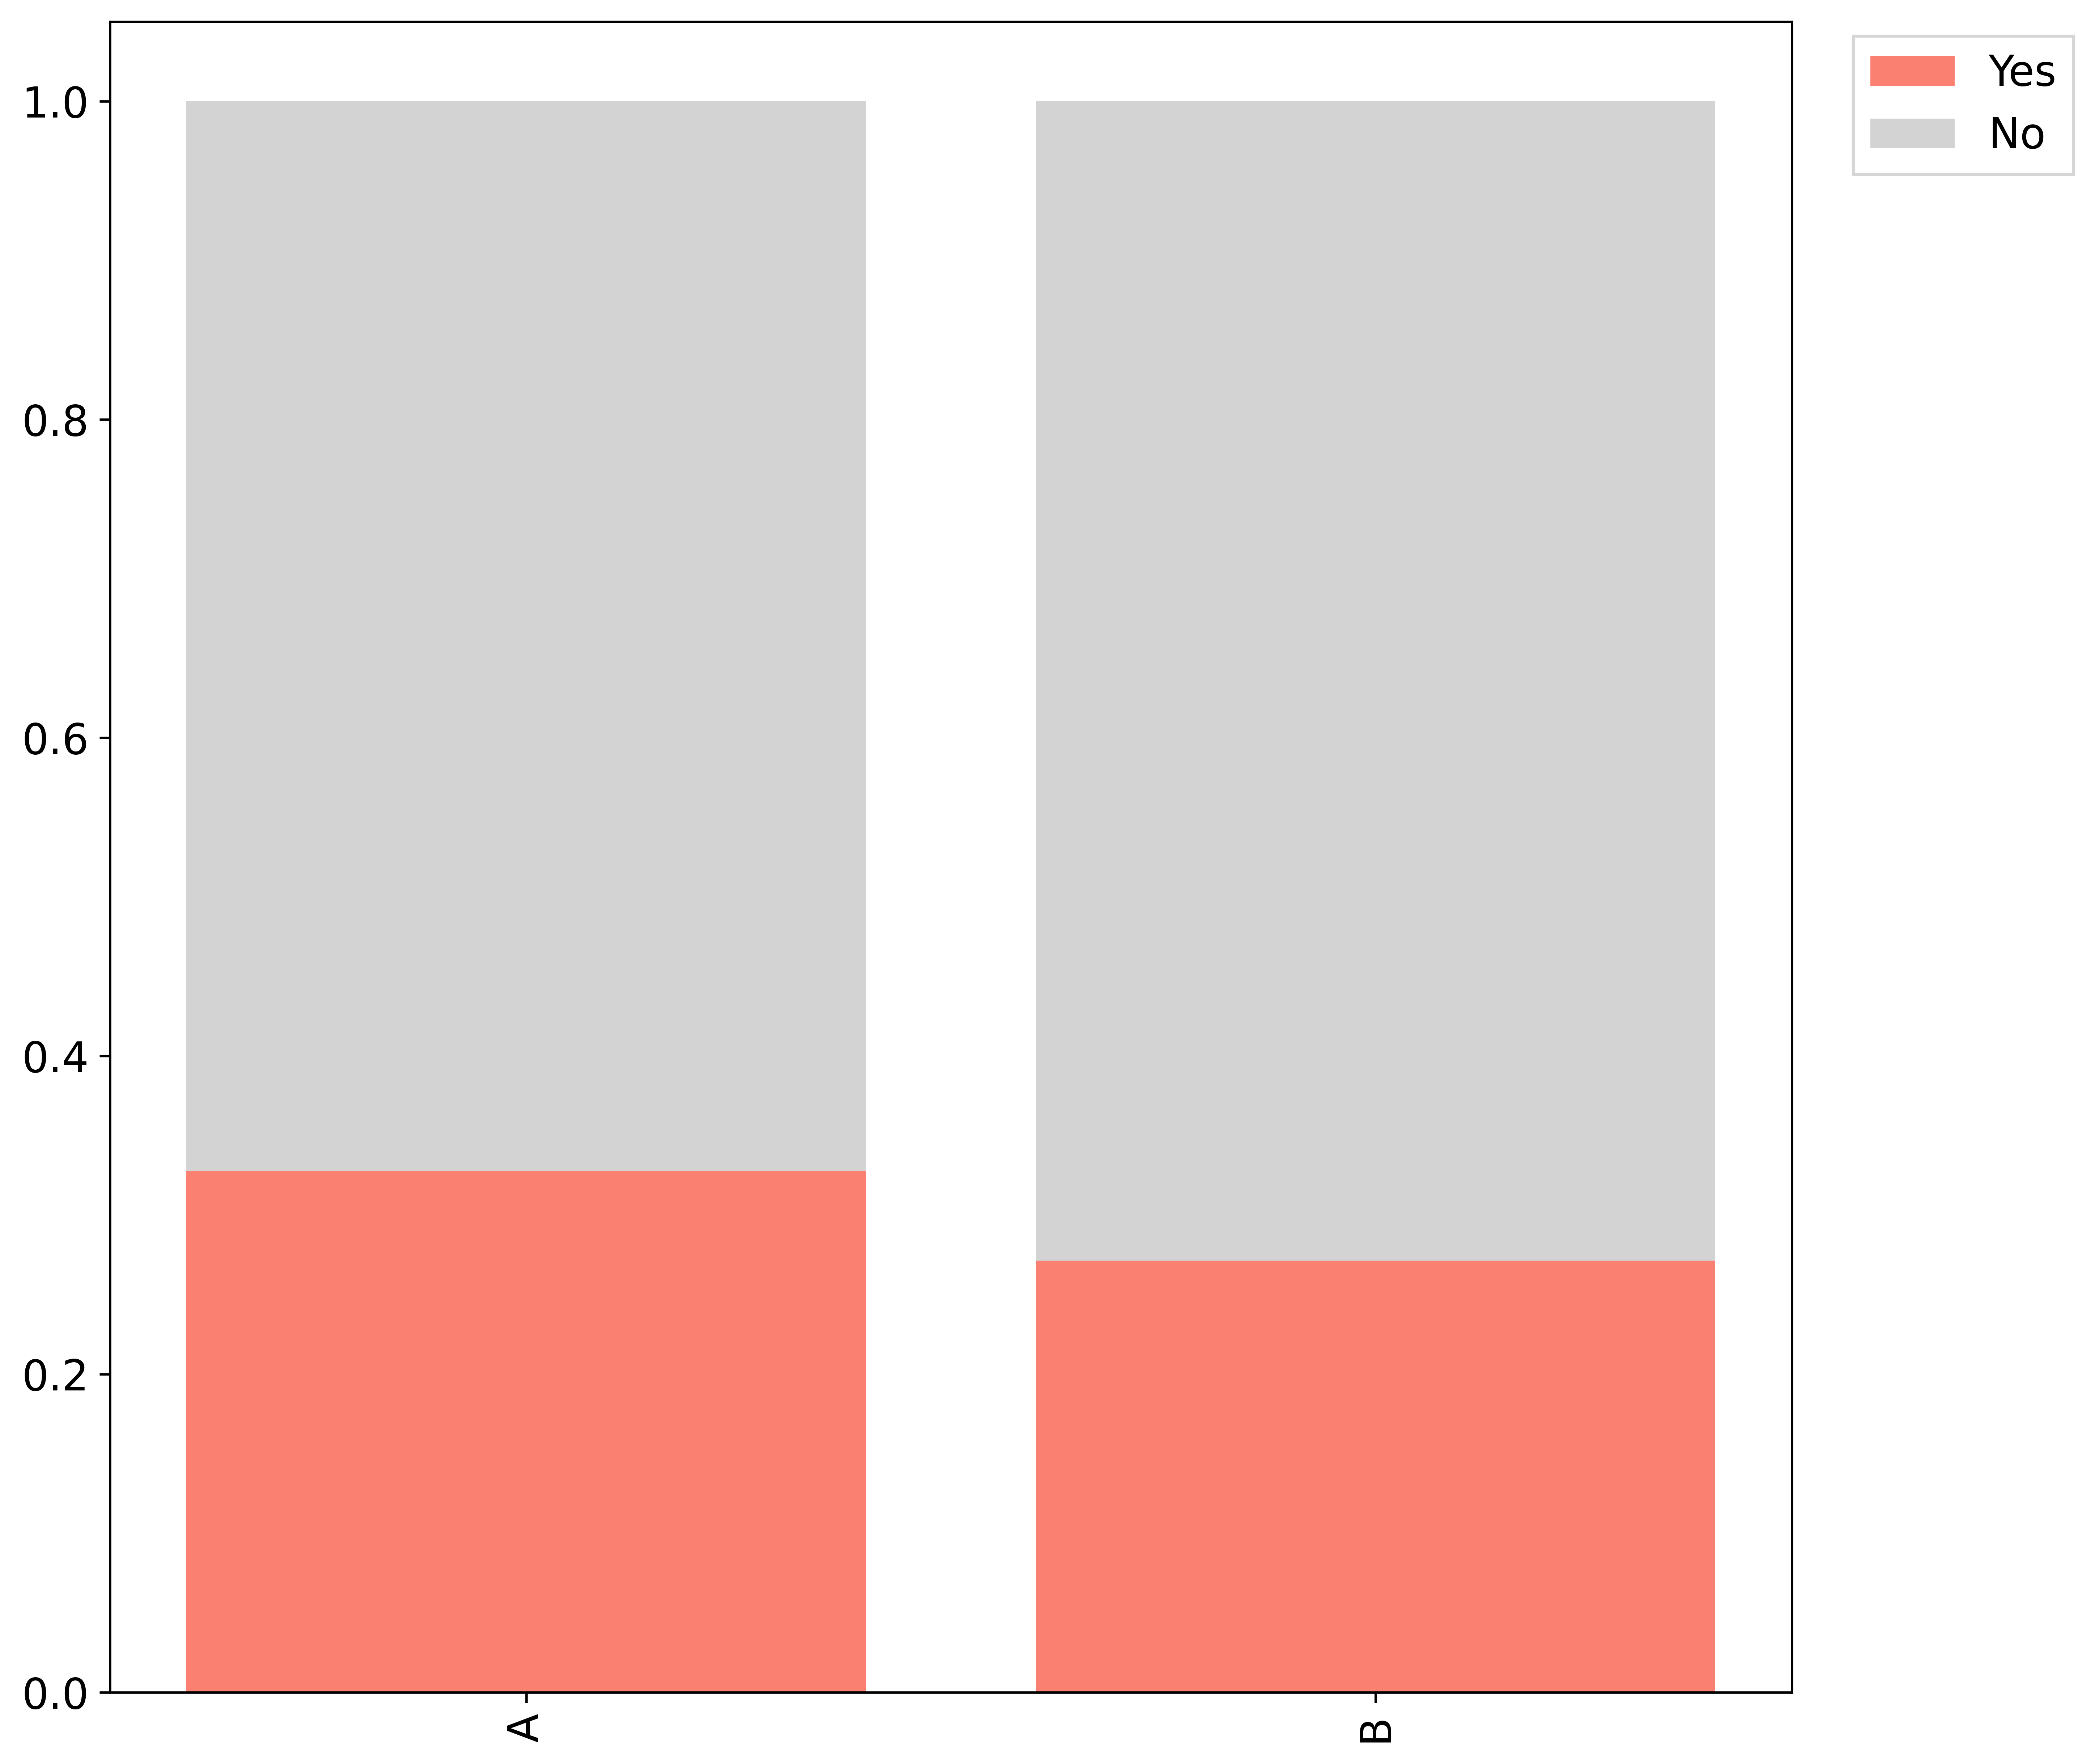

In [3]:
#Note that these numbers were extracted from the demographics table (i.e. Table in main figure)
df = pd.DataFrame({'A': [279, 136], 'B': [384,143], 'category' : ['no','yes']})
df
df1 = df.drop(columns=['category'])
data_perc = df1.divide(df1.sum(axis=0), axis=1)
data_perc1 = data_perc.T

plt.figure(figsize=(10,10), dpi=600)
plt.rcParams.update({'font.size': 14})
x = ['A','B']


#proportional
y3p = data_perc1[0]
y4p = data_perc1[1]


bars1 = plt.bar(x, y4p, color='#fa8072', label='Yes')
bars2 = plt.bar(x, y3p, bottom= y4p, color='lightgray', label='No')

plt.legend(loc='right', bbox_to_anchor=(1.18, 0.95),
          ncol=1, fancybox=False, shadow=False)
plt.xticks(rotation=90)

#plt.savefig('092923-ICU-Admission.svg', format='svg', bbox_inches='tight')